# Custom integer quantization for SNN

In [1]:
import torch
import pickle
import os
import snntorch as snn
import torch.nn as nn
import numpy as np
from collections import OrderedDict

import os

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as torchvision_transforms
import tonic
import tonic.transforms as transforms

# Define sensor size for NMNIST dataset
sensor_size = tonic.datasets.NMNIST.sensor_size

# Define transformations
# Note: The use of torch.from_numpy is removed as Tonic's transforms handle conversion.
transform = tonic.transforms.Compose([
    transforms.Denoise(filter_time=10000),
    transforms.ToFrame(sensor_size=sensor_size, time_window=10000),
    # torchvision.transforms.RandomRotation is not directly applicable to event data.
    # If rotation is needed, it should be done on the frames after conversion by ToFrame.
])

# Load NMNIST datasets without caching
trainset = tonic.datasets.NMNIST(save_to='tmp/data', transform=transform, train=True)
testset = tonic.datasets.NMNIST(save_to='tmp/data', transform=transform, train=False)

# Split trainset into training and validation datasets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Fetch a single batch from the train_loader to inspect the shape
data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}")  # Example output: torch.Size([batch_size, timesteps, channels, height, width])
print(f"Targets shape: {targets.shape}")  # Example output: torch.Size([batch_size])

/home/aleksa_tum/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data shape: torch.Size([30, 128, 2, 34, 34])
Targets shape: torch.Size([128])


In [42]:
config = {
    # SNN
    "threshold1": 2.5,
    "threshold2": 8.0,
    "threshold3": 4.0,
    "beta": 0.5,
    "num_steps": 10,
    
    # SNN Dense Shape
    "dense1_input": 2312,
    "num_classes": 10,

    # Hyper Params
    "lr": 0.007,

    # Early Stopping
    "min_delta": 1e-6,
    "patience_es": 20,

    # Training
    "epochs": 1
}

### Last model trained with FC layers and LIF


In [43]:
class SNN(nn.Module):
  def __init__(self, config, gather_mem_stats = None):
    super(SNN, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Dense Shape
    self.dense1_input = config["dense1_input"]
    self.num_classes = config["num_classes"]

      # Network Layers
    self.fc1 = nn.Linear(self.dense1_input, self.dense1_input//4)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)
    
    self.fc2 = nn.Linear(self.dense1_input//4, self.dense1_input//8)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)
    
    self.fc3 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)
    
    self.flatten = nn.Flatten()

    self.gather_mem_stats = gather_mem_stats
    if gather_mem_stats is not None:
      self.mem1_val = None
      self.mem2_val = None
      self.mem3_val = None
    
    
    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()

    spike3_rec = []
    mem3_rec = []

    for step in range(inpt.shape[0]):
      #print(inpt[step].shape)
      
      current_input = inpt[step]
      current_input = self.flatten(current_input)
      
      current1 = self.fc1(current_input)
      spike1, mem1 = self.lif1(current1, mem1)

      if self.gather_mem_stats is not None:
        if self.mem1_val is None:
          self.mem1_val = mem1.flatten().clone()
        else:
          self.mem1_val = torch.cat((self.mem1_val, mem1.flatten()))

      current2 = self.fc2(spike1)
      spike2, mem2 = self.lif2(current2, mem2)

      if self.gather_mem_stats is not None:
        if self.mem2_val is None:
          self.mem2_val = mem2.flatten().clone()
        else:
          self.mem2_val = torch.cat((self.mem2_val, mem2.flatten()))

      current3 = self.fc3(spike2)
      spike3, mem3 = self.lif3(current3, mem3)

      if self.gather_mem_stats is not None:
        if self.mem3_val is None:
          self.mem3_val = mem3.flatten().clone()
        else:
          self.mem3_val = torch.cat((self.mem3_val, mem3.flatten()))

      spike3_rec.append(spike3)
      mem3_rec.append(mem3)

    return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)

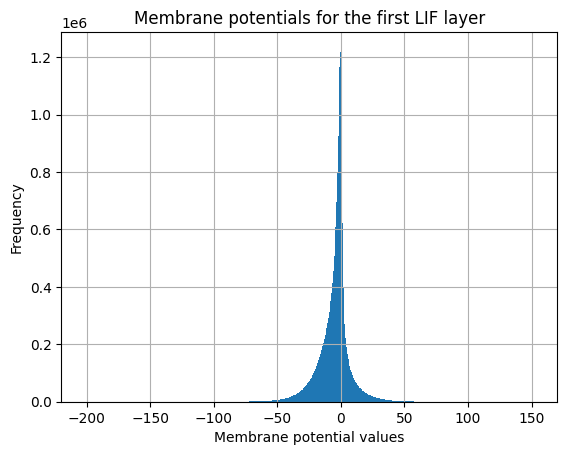

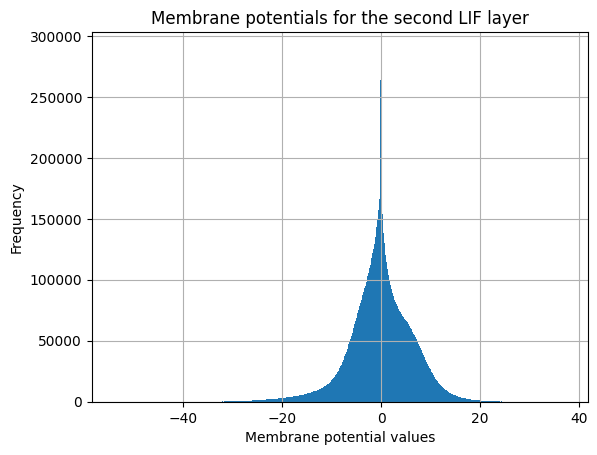

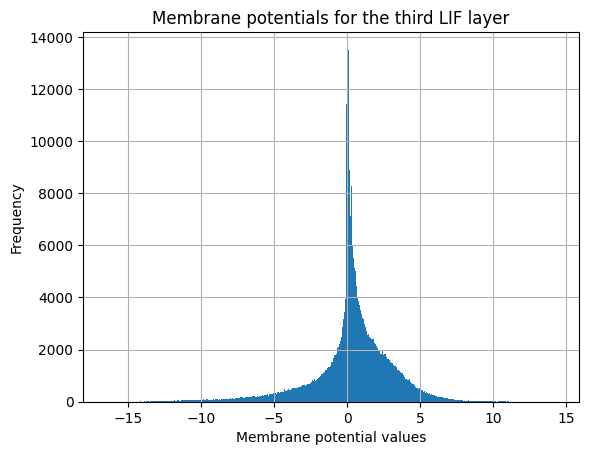

'\n# Checking tensor sizes\nprint(model.fc1.weight.data.shape)\nprint(model.fc1.bias.data.shape)\n\n\nparam_fc1 = torch.column_stack((model.fc1.weight.data, model.fc1.bias.data))\nparam_fc2 = torch.column_stack((model.fc2.weight.data, model.fc2.bias.data))\nparam_fc3 = torch.column_stack((model.fc3.weight.data, model.fc3.bias.data))\n\n\n# Plotting distributions\nplt.figure()\nplt.hist(param_fc1.flatten(), bins=1000)\nplt.title("Weights and biases for the first linear layer")\nplt.xlabel(\'Weight values\')\nplt.ylabel(\'Frequency\')\nplt.grid(True)\nplt.show()\n\nplt.figure()\nplt.hist(param_fc2.flatten(), bins=1000)\nplt.title("Weights and biases for the second linear layer")\nplt.xlabel(\'Weight values\')\nplt.ylabel(\'Frequency\')\nplt.grid(True)\nplt.show()\n\nplt.figure()\nplt.hist(param_fc3.flatten(), bins=1000)\nplt.title("Weights and biases for the third linear layer")\nplt.xlabel(\'Weight values\')\nplt.ylabel(\'Frequency\')\nplt.grid(True)\nplt.show()\n'

In [17]:
import matplotlib.pyplot as plt

# Loading model's parameters
model_path = 'best_SNN_model.pth'
model = SNN(config, True)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Calibrate the model with some training data
for i, (inputs, _) in enumerate(train_loader):
    if (i > 15): break
    model(inputs)  # Forward pass to calibrate the quantization parameters

plt.figure()
plt.hist(model.mem1_val.detach().numpy(), bins=1000)
plt.title("Membrane potentials for the first LIF layer")
plt.xlabel('Membrane potential values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(model.mem2_val.detach().numpy(), bins=1000)
plt.title("Membrane potentials for the second LIF layer")
plt.xlabel('Membrane potential values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(model.mem3_val.detach().numpy(), bins=1000)
plt.title("Membrane potentials for the third LIF layer")
plt.xlabel('Membrane potential values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

"""
# Checking tensor sizes
print(model.fc1.weight.data.shape)
print(model.fc1.bias.data.shape)


param_fc1 = torch.column_stack((model.fc1.weight.data, model.fc1.bias.data))
param_fc2 = torch.column_stack((model.fc2.weight.data, model.fc2.bias.data))
param_fc3 = torch.column_stack((model.fc3.weight.data, model.fc3.bias.data))


# Plotting distributions
plt.figure()
plt.hist(param_fc1.flatten(), bins=1000)
plt.title("Weights and biases for the first linear layer")
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(param_fc2.flatten(), bins=1000)
plt.title("Weights and biases for the second linear layer")
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(param_fc3.flatten(), bins=1000)
plt.title("Weights and biases for the third linear layer")
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
"""

In [44]:
class Quantizer:
    def __init__(self, model : nn.Module):
        self.model = model
        
    def findQuantizationParams(self, percentile_lin : list[float], percentile_lif : list[float]):
        self.scale_lin = []
        self.scale_lif = []
        self.zero_point_lif = []

        # Include biases also in the statistics, because we use the same scale for both biases and weights in the same layer
        param_fc1 = torch.column_stack((self.model.fc1.weight.data, self.model.fc1.bias.data)).flatten()
        param_fc2 = torch.column_stack((self.model.fc2.weight.data, self.model.fc2.bias.data)).flatten()
        param_fc3 = torch.column_stack((self.model.fc3.weight.data, self.model.fc3.bias.data)).flatten()

        # Finding the k-th min and max value in order to avoid outliers
        fc1_idx = (param_fc1.shape[0] - int(param_fc1.shape[0] * percentile_lin[0])) // 2
        fc2_idx = (param_fc2.shape[0] - int(param_fc2.shape[0] * percentile_lin[1])) // 2
        fc3_idx = (param_fc3.shape[0] - int(param_fc3.shape[0] * percentile_lin[2])) // 2

        # Determining the scale for the linear layers
        mink_fc1, _ = torch.kthvalue(param_fc1, fc1_idx)
        maxk_fc1, _ = torch.kthvalue(-1 * param_fc1, fc1_idx)
        max_fc1 = max(torch.abs(maxk_fc1), torch.abs(mink_fc1))
        self.scale_lin.append(2 * max_fc1.item() / 255)

        mink_fc2, _ = torch.kthvalue(param_fc2, fc2_idx)
        maxk_fc2, _ = torch.kthvalue(-1 * param_fc2, fc2_idx)
        max_fc2 = max(torch.abs(maxk_fc2), torch.abs(mink_fc2))
        self.scale_lin.append(2 * max_fc2.item() / 255)

        mink_fc3, _ = torch.kthvalue(param_fc3, fc3_idx)
        maxk_fc3, _ = torch.kthvalue(-1 * param_fc3, fc3_idx)
        max_fc3 = max(torch.abs(maxk_fc3), torch.abs(mink_fc3))
        self.scale_lin.append(2 * max_fc3.item() / 255)

        """
        print(max_fc1.item(), max_fc2.item(), 
              max_fc3.item(), self.scale_lin)
        """

        # Determining the scale and the zero_point for the LIF layers

        # Finding the k-th min and max value in order to avoid outliers
        lif1_idx = (self.model.mem1_val.shape[0] - int(self.model.mem1_val.shape[0] * percentile_lif[0])) // 2
        lif2_idx = (self.model.mem2_val.shape[0] - int(self.model.mem2_val.shape[0] * percentile_lif[1])) // 2
        lif3_idx = (self.model.mem3_val.shape[0] - int(self.model.mem3_val.shape[0] * percentile_lif[2])) // 2

        mink_lif1, _ = torch.kthvalue(self.model.mem1_val, lif1_idx)
        maxk_lif1, _ = torch.kthvalue(-1 * self.model.mem1_val, lif1_idx)
        maxk_lif1 = -maxk_lif1
        S = (maxk_lif1 - mink_lif1) / ((2 ** 16) - 1)
        self.zero_point_lif.append(int(-(2 ** 15) - torch.round(mink_lif1 / S).item()))
        self.scale_lif.append(S.item())

        mink_lif2, _ = torch.kthvalue(self.model.mem2_val, lif2_idx)
        maxk_lif2, _ = torch.kthvalue(-1 * self.model.mem2_val, lif2_idx)
        maxk_lif2 = -maxk_lif2
        S = (maxk_lif2 - mink_lif2) / ((2 ** 16) - 1)
        self.zero_point_lif.append(int(-(2 ** 15) - torch.round(mink_lif2 / S).item()))
        self.scale_lif.append(S.item())

        mink_lif3, _ = torch.kthvalue(self.model.mem3_val, lif3_idx)
        maxk_lif3, _ = torch.kthvalue(-1 * self.model.mem3_val, lif3_idx)
        maxk_lif3 = -maxk_lif3
        S = (maxk_lif3 - mink_lif3) / ((2 ** 16) - 1)
        self.zero_point_lif.append(int(-(2 ** 15) - torch.round(mink_lif3 / S).item()))
        self.scale_lif.append(S.item())

        """
        print(maxk_lif1.item(), mink_lif1.item(), 
              maxk_lif2.item(), mink_lif2.item(), 
              maxk_lif3.item(), mink_lif3.item(), 
              self.scale_lif, self.zero_point_lif)
        """
    
        return self.scale_lin, self.scale_lif, self.zero_point_lif

    def quantize(self):
        W = [self.model.fc1.weight.data, self.model.fc2.weight.data, self.model.fc3.weight.data]
        B = [self.model.fc1.bias.data, self.model.fc2.bias.data, self.model.fc3.bias.data]

        Thresh = [self.model.thresh1, self.model.thresh2, self.model.thresh3]

        Wq = []
        Bq = []
        Threshq = []
        for i in range(len(W)):
            Wq.append((torch.round(W[i] / self.scale_lin[i])))
            Bq.append((torch.round(B[i] / self.scale_lin[i])))
            Wq[-1][Wq[-1] > 127] = 127
            Wq[-1][Wq[-1] < -128] = -128
            Wq[-1] = Wq[-1].type(torch.int8)
            Bq[-1][Bq[-1] > 127] = 127
            Bq[-1][Bq[-1] < -128] = -128
            Bq[-1] = Bq[-1].type(torch.int8)

            Threshq.append(round(Thresh[i] / self.scale_lif[i]) + self.zero_point_lif[i])
            if Threshq[-1] > ((2 ** 15) - 1):
               Threshq[-1] = ((2 ** 15) - 1)
            
            if Threshq[-1] < -(2 ** 15):
                Threshq[-1] = -(2 ** 15)

        return Wq, Bq, Threshq


# Loading model's parametersi
model_path = 'best_SNN_model.pth'
model = SNN(config, True)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Calibrate the model with some training data
for i, (inputs, _) in enumerate(train_loader):
    if (i > 5): break
    model(inputs)  # Forward pass to calibrate the quantization parameters

Q = Quantizer(model)
s_lin, s_lif, z_lif = Q.findQuantizationParams([0.985, 0.985, 0.95], [0.985, 0.985, 0.95])
Wq, Bq, Threshq = Q.quantize()

In [79]:
def matMACQuantized(W, B, x):
    
    y = torch.matmul(W.float(), x.float()) + B.float()
    min_value = torch.iinfo(torch.int16).min
    max_value = torch.iinfo(torch.int16).max
    y = torch.clamp(y, min_value, max_value).type(torch.int16)

    """
    y = torch.empty(B.shape[0], dtype=torch.int16)
    for i in range(W.shape[0]):
        r = 0
        for j in range(W.shape[1]):
            r += W[i, j] * x[j]
            if r > (2 ** 15) - 1:
                r = (2 ** 15) - 1
            if r < -(2 ** 15):
                r = -(2 ** 15)
        y[i] = r + B[i]
    """
    return y.type(torch.int16)

def LifQuantized(Isyn, mem, thresh, beta_shift_amt, z_lif, coeff, spike):
    const1 = 2 * z_lif - ((z_lif + thresh) >> beta_shift_amt)
    const2 = z_lif - (z_lif >> beta_shift_amt)

    mem = (mem.type(torch.int16) >> beta_shift_amt) + torch.round(coeff * Isyn)
    mem[mem > ((2 ** 15) - 1)] = ((2 ** 15) - 1)
    mem[mem < -(2 ** 15)] = -(2 ** 15)
    
    for i in range(mem.shape[0]):
        if spike[i] == 1:
            mem[i] += const2
        else:
            mem[i] += const1
    
    mem[mem > ((2 ** 15) - 1)] = ((2 ** 15) - 1)
    mem[mem < -(2 ** 15)] = -(2 ** 15)

    S = torch.zeros(mem.shape[0], dtype=torch.int8)
    S[mem > thresh] = 1

    return S, mem

def runNetworkQuantized(Wq, Bq, Threshq, s_lin, s_lif, z_lif, config, inpt, targets):

    calc_target = []

    for i in range(inpt.shape[1]):
        x = inpt[:, i, :, :, :]
    
        mem1 = torch.zeros(config["dense1_input"] // 4)
        spike1 = torch.zeros(config["dense1_input"] // 4)

        mem2 = torch.zeros(config["dense1_input"] // 8)
        spike2 = torch.zeros(config["dense1_input"] // 8)

        mem3 = torch.zeros(config["num_classes"])
        spike3 = torch.zeros(config["num_classes"])

        pred = torch.zeros(config["num_classes"])
        
        for step in range(x.shape[0]):
        
            current_input = x[step].flatten()
        
            current1 = matMACQuantized(Wq[0], Bq[0], current_input)
            spike1, mem1 = LifQuantized(current1, mem1, Threshq[0], 1, z_lif[0], s_lin[0]/s_lif[0], spike1)

            current2 = matMACQuantized(Wq[1], Bq[1], spike1)
            spike2, mem2 = LifQuantized(current2, mem2, Threshq[1], 1, z_lif[1], s_lin[1]/s_lif[1], spike2)

            current3 = matMACQuantized(Wq[2], Bq[2], spike2)
            spike3, mem3 = LifQuantized(current3, mem3, Threshq[2], 1, z_lif[2], s_lin[2]/s_lif[2], spike3)

            pred += spike3

        print("Predicted class: ", pred.argmax().item())
        print("Correct class: ", targets[i])
        
        calc_target.append(pred.argmax().item())
    
    calc_target = torch.tensor(calc_target)
    calc_target = calc_target - targets
    correct = calc_target.shape[0] - torch.count_nonzero(calc_target).item()
    print("Accuracy: ", correct / calc_target.shape[0])

In [80]:
for data, targets in test_loader:
    runNetworkQuantized(Wq, Bq, Threshq, s_lin, s_lif, z_lif, config, data, targets)
    break

Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  2
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  3
Correct class:  tensor(1)
Predicted class:  2
Correct class:

KeyboardInterrupt: 

In [20]:

def myLIF(Isyn, mem, beta, thresh):
    
    if mem > thresh:
        R = 1
    else:
        R = 0
    mem = beta * mem + Isyn - R * thresh
    return R, mem

lif = snn.Leaky(beta=0.5, threshold=2)

curr = torch.tensor([1.1])
mem = lif.init_leaky()
print(mem)

#print("My result: ", myLIF(curr, mem, 0.5, 2.5))
spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

#print("My result: ", myLIF(curr, mem, 0.5, 2.5))
spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

spk, mem = lif(curr, mem)
print("Correct result: ", spk, mem)

_SpikeTensor([])
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.1000], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.6500], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.9250], grad_fn=<AddBackward0>)
Correct result:  tensor([1.], grad_fn=<MulBackward0>) tensor([2.0625], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.1313], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.6656], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.9328], grad_fn=<AddBackward0>)
Correct result:  tensor([1.], grad_fn=<MulBackward0>) tensor([2.0664], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.1332], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], grad_fn=<MulBackward0>) tensor([1.6666], grad_fn=<AddBackward0>)
Correct result:  tensor([0.], gra